<h1 style="text-align: center; font-weight: bold; font-size: 36px;">Makemore Part 4: Backprop Ninja</h1>

# Introduction

Manual backprop through a **MLP** model. Pen-and-paper derivations

Inspired by Karpathy [Neural Networks: Zero-to-Hero](https://github.com/karpathy/nn-zero-to-hero). 
We are using the same [names.txt](https://github.com/karpathy/makemore/blob/master/names.txt) as in Zero to Hero so we can compare results.

# Imports

In [1]:
import random
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Build the Dataset

In [2]:
with open('../data/names.txt', 'r') as f:
    names = f.read().splitlines()
print("Num names:", len(names))
print("Example names:", names[:10])
print("Min length:", min(len(name) for name in names))
print("Max length:", max(len(name) for name in names))

Num names: 32033
Example names: ['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']
Min length: 2
Max length: 15


In [3]:
# Get vocabulary
letters = sorted(list(set(''.join(names))))
letters = ['.'] + letters
n_vocab = len(letters)
print(letters)

['.', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [4]:
class Tokenizer:
    def __init__(self, vocab):
        assert isinstance(vocab, list)
        assert all(isinstance(v, str) for v in vocab)
        assert all(len(v) == 1 for v in vocab)
        self.stoi = {ch: i for i, ch in enumerate(vocab)}
        self.itos = {i: ch for i, ch in enumerate(vocab)}

    def encode(self, text):
        return [self.stoi[s] for s in text]

    def decode(self, sequence):
        if isinstance(sequence, list):
            return ''.join([self.itos[i] for i in sequence])
        elif isinstance(sequence, torch.Tensor):
            assert sequence.ndim in [0, 1]
            if sequence.ndim == 0:
                return self.itos[sequence.item()]  # one char
            else:
                return ''.join([self.itos[i.item()] for i in sequence])
        else:
            raise ValueError(f"Type {type(sequence)} not supported")

In [5]:
def build_dataset(tok, block_size, names):
    X, Y = [], []  # inputs and targets
    for name in names:
        name = '.'*block_size + name + '.'  # add start/stop tokens '..emma.'
        for i in range(len(name) - block_size):
            X.append(tok.encode(name[i:i+block_size]))
            Y.append(tok.encode(name[i+block_size])[0])  # [0] to keep Y 1d tensor
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

In [6]:
block_size = 3  # context length
tok = Tokenizer(vocab=letters)

random.seed(42)
random.shuffle(names)
n1 = int(0.8*len(names))
n2 = int(0.9*len(names))

Xtr, Ytr = build_dataset(tok, block_size, names[:n1])
Xval, Yval = build_dataset(tok, block_size, names[n1:n2])
Xtest, Ytest = build_dataset(tok, block_size, names[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [7]:
def cmp(s, at, bt):
    ex = torch.all(at == bt).item()
    app = torch.allclose(at, bt)
    maxdiff = (at - bt).abs().max().item()
    print(f'{s:18s} | exat: {str(ex):5s} | approx: {str(app):5s} | maxdiff: {maxdiff}')

In [8]:
# Init Layers
# NOTE: PyTorch F.cross_entropy uses multiple optimizations casuing slight
# numerical differences. This "lucky seed" makes our manual and PyTorch losses match.
# NOTE: instead of 1/x use x**-0.5, PyTorch kernels are not reproducible with 1/x
torch.manual_seed(0)

# Hyperparameters
n_batch = 32
n_embd = 10
n_hid = 64

# Model
# NOTE: Init all params to non-zero so we don't mask gradient issues
C = torch.randn((n_vocab, n_embd))                              # n_vocab, n_emb (embeddings)
W1_kaiming_init = (5/3)/((n_embd*block_size)**0.5)              # tanh_gain / sqrt(fan_in)
W1 = torch.randn((n_embd*block_size, n_hid)) * W1_kaiming_init  # n_seq*n_emb, n_hid
b1 = torch.randn(n_hid)                      * 0.1              # n_hid
bngain = torch.randn((1, n_hid))             * 0.1 + 1.0        # 1, n_hid
bnbias = torch.randn((1, n_hid))             * 0.1              # 1, n_hid
W2 = torch.randn((n_hid, n_vocab))           * 0.1              # n_hid, n_out
b2 = torch.randn(n_vocab)                    * 0.1              # 1, n_out

# Gather Params
params = [C, W1, b1, bngain, bnbias, W2, b2]
for p in params:
    p.requires_grad = True

# Random mini batch
batch_indices = torch.randint(0, Xtr.shape[0], (n_batch,))
x_batch = Xtr[batch_indices]
y_batch = Ytr[batch_indices]

In [9]:
# Forward Pass

# Embedding
emb = C[x_batch]                                  # n_batch, n_seq, n_emb
embcat = emb.view(-1, n_embd*block_size)          # n_batch, n_embd*block_size

# Linear 1
z1 = embcat @ W1 + b1                             # n_batch, n_hid

# Bachnorm 1
# zx = (x - x_mean) / (x_var + 1e-5)**0.5
# bn(x) = zx * gain + bias
# Batchnorm 1 - mean
z1_sum = z1.sum(dim=0, keepdim=True)              # 1, n_hid
z1_mean = z1_sum / n_batch                        # 1, n_hid
# Batchnorm 1 - var
z1_diff = z1 - z1_mean                            # n_batch, n_hid
z1_diff_2 = z1_diff**2.0                          # n_batch, n_hid
z1_diff_sum = z1_diff_2.sum(dim=0, keepdim=True)  # 1, n_hid
z1_var = z1_diff_sum * (n_batch-1)**-1            # 1, n_hid
# Batchnorm 1 - correction
z1_var_p_eps = z1_var + 1e-5                      # 1, n_hid
z1_var_sqrt_inv = z1_var_p_eps**-0.5              # 1, n_hid
zx = z1_diff * z1_var_sqrt_inv                    # n_batch, n_hid
# Batchnorm 1 - scaling
zz = bngain * zx + bnbias                         # n_batch, n_hid

# Tanh 1
# tanh(x) = (torch.exp(2*x) - 1.0) / (torch.exp(2*x) + 1)
zz_2 = 2*zz                                 # n_batch, n_hid
zz_2_exp = zz_2.exp()                       # n_batch, n_hid
zz_2_exp_m1 = zz_2_exp - 1.0                # n_batch, n_hid
zz_2_exp_p1 = zz_2_exp + 1.0                # n_batch, n_hid
zz_2_exp_p1_inv = zz_2_exp_p1**-1           # n_batch, n_hid
h1 = zz_2_exp_m1 * zz_2_exp_p1_inv          # n_batch, n_hid

# Linear 2
logits = h1 @ W2 + b2                       # n_batch, n_vocab

# Softmax
logits_max = logits.max(dim=-1, keepdim=True).values      # n_batch, 1
logits_diff = logits - logits_max                         # n_batch, n_vocab
logits_exp = logits_diff.exp()                            # n_batch, n_vocab
logits_exp_sum = logits_exp.sum(dim=-1, keepdim=True)     # n_batch, 1
logits_exp_sum_inv = logits_exp_sum**-1                   # n_batch, 1
probs = logits_exp * logits_exp_sum_inv                   # n_batch, n_vocab

# Cross Entropy
log_probs = probs.log()                                         # n_batch, n_vocab
log_probs_target = log_probs[range(n_batch), y_batch]           # n_batch
loss = -log_probs_target.sum(dim=0, keepdim=True) / n_batch

# PyTorch Backward Pass
for p in params:
    p.grad = None
for t in [
        emb, embcat,
        z1,
        z1_sum, z1_mean,
        z1_diff, z1_diff_2, z1_diff_sum, z1_var,
        z1_var_p_eps, z1_var_sqrt_inv, zx,
        zz,
        zz_2, zz_2_exp, zz_2_exp_m1, zz_2_exp_p1, zz_2_exp_p1_inv, h1,
        logits,
        logits_max, logits_diff, logits_exp, logits_exp_sum, logits_exp_sum_inv, probs,
        log_probs, log_probs_target, loss
    ]:
    t.retain_grad()

loss.backward()

with torch.no_grad():
    # PyTorch loss: 3.3894288539886475
    print(f"PyTorch loss: {F.cross_entropy(logits, y_batch).item()}")
    print(f"              {loss.item()}")

PyTorch loss: 3.3894288539886475
              3.3894288539886475


In [10]:
with torch.no_grad():
    
    # Cross Entropy
    d_loss = torch.tensor(1.0)
    d_log_probs_target = -1 * torch.ones(n_batch) * (1/n_batch * d_loss)
    d_log_probs = torch.zeros_like(log_probs)
    d_log_probs[range(n_batch), y_batch] = d_log_probs_target

    # Softmax
    d_probs = (1 / probs) * d_log_probs    # deriv of ln * chain rule
    d_logits_exp_sum_inv = (logits_exp * d_probs).sum(dim=-1, keepdim=True)
    d_logits_exp_sum = -1 * logits_exp_sum**-2 * d_logits_exp_sum_inv
    d_logits_exp = torch.ones_like(logits_exp) * d_logits_exp_sum
    d_logits_exp += logits_exp_sum_inv * d_probs  # second gradient path
    d_logits_diff = logits_exp * d_logits_exp
    d_logits_max = -d_logits_diff.sum(dim=-1, keepdim=True)   # n_batch, 1
    d_logits = d_logits_diff.clone()  # logits_diff path
    logits_maxi = logits.max(dim=-1).indices
    d_logits[range(n_batch), logits_maxi] += d_logits_max[range(n_batch), 0]   # max path

    # Linear 2
    d_h1 = d_logits @ W2.T
    d_W2 = h1.T @ d_logits
    d_b2 = d_logits.sum(dim=0)

    # Tanh 1
    d_zz_2_exp_p1_inv = zz_2_exp_m1 * d_h1
    d_zz_2_exp_p1 = -1 * zz_2_exp_p1**-2 * d_zz_2_exp_p1_inv
    d_zz_2_exp_m1 = zz_2_exp_p1_inv * d_h1
    d_zz_2_exp = d_zz_2_exp_p1 + d_zz_2_exp_m1
    d_zz_2 = zz_2_exp * d_zz_2_exp
    d_zz = 2 * d_zz_2

    # Batch Norm 1 - scaling
    d_bngain = (zx * d_zz).sum(dim=0, keepdim=True)
    d_bnbias = d_zz.sum(dim=0, keepdim=True)
    # Batch Norm 1 - correction
    d_zx = torch.ones_like(zx) * bngain * d_zz
    d_z1_var_sqrt_inv = (z1_diff * d_zx).sum(dim=0, keepdim=True)
    d_z1_var_p_eps = -0.5*z1_var_p_eps**-1.5 * d_z1_var_sqrt_inv
    # Batch Norm 1 - var
    d_z1_var = d_z1_var_p_eps.clone()
    d_z1_diff_sum = (n_batch-1)**-1 * d_z1_var
    d_z1_diff_2 = torch.ones_like(z1_diff_2) * d_z1_diff_sum
    d_z1_diff = 2 * z1_diff * d_z1_diff_2
    d_z1_diff += d_zx * z1_var_sqrt_inv  # second path
    # Batch Norm 1 - mean
    d_z1_mean = -1 * d_z1_diff.sum(dim=0, keepdim=True)
    d_z1_sum = 1/n_batch * d_z1_mean
    d_z1 = torch.ones_like(z1) * d_z1_sum
    d_z1 += d_z1_diff

    # Linear 1
    d_embcat = d_z1 @ W1.T
    d_W1 = embcat.T @ d_z1
    d_b1 = d_z1.sum(dim=0)

    # Embedding
    d_emb = d_embcat.view(-1, block_size, n_embd)
    d_C = torch.zeros_like(C)
    d_C.index_add_(0, x_batch.view(-1), d_emb.view(-1, n_embd))


In [11]:
# Cross Entropy
cmp("loss", d_loss, loss.grad)
cmp("log_probs_target", d_log_probs_target, log_probs_target.grad)
cmp("log_probs", d_log_probs, log_probs.grad)

# Softmax
cmp("probs", d_probs, probs.grad)
cmp("logits_exp_sum_inv", d_logits_exp_sum_inv, logits_exp_sum_inv.grad)
cmp("logits_exp_sum", d_logits_exp_sum, logits_exp_sum.grad)
cmp("logits_exp", d_logits_exp, logits_exp.grad)
cmp("logits_diff", d_logits_diff, logits_diff.grad)
cmp("logits_max", d_logits_max, logits_max.grad)
cmp("logits", d_logits, logits.grad)

# Linear 2
cmp("h1", d_h1, h1.grad)
cmp("W2", d_W2, W2.grad)
cmp("b2", d_b2, b2.grad)

loss               | exat: True  | approx: True  | maxdiff: 0.0
log_probs_target   | exat: True  | approx: True  | maxdiff: 0.0
log_probs          | exat: True  | approx: True  | maxdiff: 0.0
probs              | exat: True  | approx: True  | maxdiff: 0.0
logits_exp_sum_inv | exat: True  | approx: True  | maxdiff: 0.0
logits_exp_sum     | exat: True  | approx: True  | maxdiff: 0.0
logits_exp         | exat: True  | approx: True  | maxdiff: 0.0
logits_diff        | exat: True  | approx: True  | maxdiff: 0.0
logits_max         | exat: True  | approx: True  | maxdiff: 0.0
logits             | exat: True  | approx: True  | maxdiff: 0.0
h1                 | exat: True  | approx: True  | maxdiff: 0.0
W2                 | exat: True  | approx: True  | maxdiff: 0.0
b2                 | exat: True  | approx: True  | maxdiff: 0.0


In [12]:
# Tanh 1
cmp("zz_2_exp_p1_inv", d_zz_2_exp_p1_inv, zz_2_exp_p1_inv.grad)
cmp("zz_2_exp_p1", d_zz_2_exp_p1, zz_2_exp_p1.grad)
cmp("zz_2_exp_m1", d_zz_2_exp_m1, zz_2_exp_m1.grad)
cmp("zz_2_exp", d_zz_2_exp, zz_2_exp.grad)
cmp("zz_2", d_zz_2, zz_2.grad)

# Batch Norm 1 - scaling
cmp("zz", d_zz, zz.grad)
cmp("bngain", d_bngain, bngain.grad)
cmp("bnbias", d_bnbias, bnbias.grad)
# Batch Norm 1 - correction
cmp("zx", d_zx, zx.grad)
cmp("z1_var_sqrt_inv", d_z1_var_sqrt_inv, z1_var_sqrt_inv.grad)
cmp("z1_var_p_eps", d_z1_var_p_eps, z1_var_p_eps.grad)
# Batch Norm 1 - var
cmp("z1_var", d_z1_var, z1_var.grad)
cmp("z1_diff_sum", d_z1_diff_sum, z1_diff_sum.grad)
cmp("z1_diff_2", d_z1_diff_2, z1_diff_2.grad)
cmp("z1_diff", d_z1_diff, z1_diff.grad)
# Batch Norm 1 - mean
cmp("z1_mean", d_z1_mean, z1_mean.grad)
cmp("z1_sum", d_z1_sum, z1_sum.grad)
cmp("z1", d_z1, z1.grad)

# Linear 1
cmp("embcat", d_embcat, embcat.grad)
cmp("W1", d_W1, W1.grad)
cmp("b1", d_b1, b1.grad)

# Embedding
cmp("emb", d_emb, emb.grad)
cmp("C", d_C, C.grad)

zz_2_exp_p1_inv    | exat: True  | approx: True  | maxdiff: 0.0
zz_2_exp_p1        | exat: True  | approx: True  | maxdiff: 0.0
zz_2_exp_m1        | exat: True  | approx: True  | maxdiff: 0.0
zz_2_exp           | exat: True  | approx: True  | maxdiff: 0.0
zz_2               | exat: True  | approx: True  | maxdiff: 0.0
zz                 | exat: True  | approx: True  | maxdiff: 0.0
bngain             | exat: True  | approx: True  | maxdiff: 0.0
bnbias             | exat: True  | approx: True  | maxdiff: 0.0
zx                 | exat: True  | approx: True  | maxdiff: 0.0
z1_var_sqrt_inv    | exat: True  | approx: True  | maxdiff: 0.0
z1_var_p_eps       | exat: True  | approx: True  | maxdiff: 0.0
z1_var             | exat: True  | approx: True  | maxdiff: 0.0
z1_diff_sum        | exat: True  | approx: True  | maxdiff: 0.0
z1_diff_2          | exat: True  | approx: True  | maxdiff: 0.0
z1_diff            | exat: True  | approx: True  | maxdiff: 0.0
z1_mean            | exat: True  | appro

# Cross Entropy - derive better graddient

Loss:
$$
\mathcal{L} = -\sum_{i} y_i \log(p_i)
$$

Softmax:
$$
p_i = \frac{e^{z_i}}{\sum_j e^{z_j}}
$$

Gradient
$$
\frac{\partial \mathcal{L}}{\partial \mathbf{z}} = \mathbf{p} - \mathbf{y}
$$

In [13]:
# Forwawrd - before

# # Softmax
# logits_max = logits.max(dim=-1, keepdim=True).values      # n_batch, 1
# logits_diff = logits - logits_max                         # n_batch, n_vocab
# logits_exp = logits_diff.exp()                            # n_batch, n_vocab
# logits_exp_sum = logits_exp.sum(dim=-1, keepdim=True)     # n_batch, 1
# logits_exp_sum_inv = logits_exp_sum**-1                   # n_batch, 1
# probs = logits_exp * logits_exp_sum_inv                   # n_batch, n_vocab

# # Cross Entropy
# log_probs = probs.log()                                         # n_batch, n_vocab
# log_probs_target = log_probs[range(n_batch), y_batch]           # n_batch
# loss = -log_probs_target.sum(dim=0, keepdim=True) / n_batch

# Forward - new
with torch.no_grad():
    loss_xxx = F.cross_entropy(logits, y_batch)

cmp("loss_xxx", loss_xxx, loss)

loss_xxx           | exat: True  | approx: True  | maxdiff: 0.0


In [14]:
# Backward - before

# # Cross Entropy
# d_loss = torch.tensor(1.0)
# d_log_probs_target = -1 * torch.ones(n_batch) * (1/n_batch * d_loss)
# d_log_probs = torch.zeros_like(log_probs)
# d_log_probs[range(n_batch), y_batch] = d_log_probs_target

# # Softmax
# d_probs = (1 / probs) * d_log_probs    # deriv of ln * chain rule
# d_logits_exp_sum_inv = (logits_exp * d_probs).sum(dim=-1, keepdim=True)
# d_logits_exp_sum = -1 * logits_exp_sum**-2 * d_logits_exp_sum_inv
# d_logits_exp = torch.ones_like(logits_exp) * d_logits_exp_sum
# d_logits_exp += logits_exp_sum_inv * d_probs  # second gradient path
# d_logits_diff = logits_exp * d_logits_exp
# d_logits_max = -d_logits_diff.sum(dim=-1, keepdim=True)   # n_batch, 1
# d_logits = d_logits_diff.clone()  # logits_diff path
# logits_maxi = logits.max(dim=-1).indices
# d_logits[range(n_batch), logits_maxi] += d_logits_max[range(n_batch), 0]   # max path

# Backward - new
with torch.no_grad():
    d_logits_xxx = F.softmax(logits, dim=1)
    d_logits_xxx[range(n_batch), y_batch] -= 1
    d_logits_xxx /= n_batch

cmp("logits", d_logits_xxx, logits.grad)

logits             | exat: False | approx: True  | maxdiff: 5.820766091346741e-09


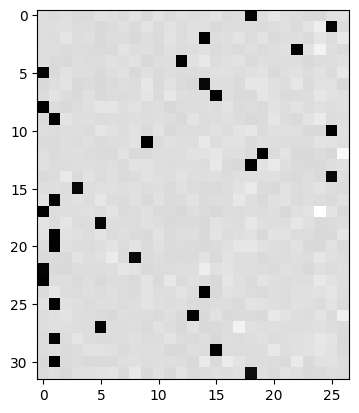

In [15]:
plt.imshow(d_logits_xxx.detach(), cmap='gray')
plt.show()

# Tanh - derive better graddient

Tanh

$$
\tanh(x) = \frac{e^{x} - e^{-x}}{e^{x} + e^{-x}}
$$

Gradient

$$
\frac{\partial \tanh(x)}{\partial x} = 1 - \tanh^2(x)
$$

In [16]:
# Forward - old

# # Tanh 1
# # tanh(x) = (torch.exp(2*x) - 1.0) / (torch.exp(2*x) + 1)
# zz_2 = 2*zz                                 # n_batch, n_hid
# zz_2_exp = zz_2.exp()                       # n_batch, n_hid
# zz_2_exp_m1 = zz_2_exp - 1.0                # n_batch, n_hid
# zz_2_exp_p1 = zz_2_exp + 1.0                # n_batch, n_hid
# zz_2_exp_p1_inv = zz_2_exp_p1**-1           # n_batch, n_hid
# h1 = zz_2_exp_m1 * zz_2_exp_p1_inv          # n_batch, n_hid

# Forward - new
with torch.no_grad():
    h1_xxx = torch.tanh(zz)

cmp("h1_xxx", h1_xxx, h1)

h1_xxx             | exat: False | approx: True  | maxdiff: 1.1920928955078125e-07


In [ ]:
# Backward - old

# # Tanh 1
# d_zz_2_exp_p1_inv = zz_2_exp_m1 * d_h1
# d_zz_2_exp_p1 = -1 * zz_2_exp_p1**-2 * d_zz_2_exp_p1_inv
# d_zz_2_exp_m1 = zz_2_exp_p1_inv * d_h1
# d_zz_2_exp = d_zz_2_exp_p1 + d_zz_2_exp_m1
# d_zz_2 = zz_2_exp * d_zz_2_exp
# d_zz = 2 * d_zz_2

# Backward - new
with torch.no_grad():
    d_zz_xxx = (1 - torch.tanh(zz)**2)  *   d_h1  # don't forget chain rule
cmp("d_zz_xxx", d_zz_xxx, zz.grad)

d_zz_xxx           | exat: False | approx: True  | maxdiff: 1.6298145055770874e-09


# Batch Norm - derive better graddient

Mean:
$$
\mu = \frac{1}{m} \sum x_i
$$

Variance:
$$
\sigma^2 = \frac{1}{m-1} \sum (x_i - \mu)^2
$$

Normalized value:
$$
\hat{x}_i = \frac{x_i - \mu}{\sqrt{\sigma^2 + \epsilon}}
$$

Scale and shift:
$$
y_i = \gamma \hat{x}_i + \beta
$$

Computation Flow:
- top: path through the $\mu$
- mid: path through the $\sigma^2$, note gradient $\sigma^2\rightarrow\mu$ is zero, hence crossed arrow
- bottom: direct path

$$
\begin{bmatrix} \vdots \\ x \\ \vdots \end{bmatrix}
\begin{array}{ccc}
 \rightarrow & \mu & \rightarrow \\
 & \downarrow \!\!\! \times & \\
 \rightarrow & \sigma^2 & \rightarrow \\
 & & \\
 & \longrightarrow &
\end{array}
\begin{bmatrix} \vdots \\ \hat{x} \\ \vdots \end{bmatrix}
\rightarrow
\begin{bmatrix} \vdots \\ y \\ \vdots \end{bmatrix}
\rightarrow
L
$$

Our target:

$$
\frac{\partial L}{\partial x_i} = \sum_j \frac{\partial L}{\partial \hat{x}_j} \cdot \frac{d\hat{x}_j}{dx_i}
$$

The first term $\frac{\partial L}{\partial \hat{x}_j}$ where $\frac{\partial L}{\partial y_j}$ is upstream gradient:

$$
\frac{\partial L}{\partial \hat{x}_j} = \frac{\partial L}{\partial y_j} \cdot \gamma
$$

Now the $\frac{d\hat{x}_j}{dx_i}$ term, note three paths: direct, through $\mu$ and $\sigma^2$:
$$
\frac{d\hat{x}_j}{dx_i} = \frac{\partial \hat{x}_j}{\partial x_i} + \frac{\partial \hat{x}_j}{\partial \mu} \cdot \frac{\partial \mu}{\partial x_i} + \frac{\partial \hat{x}_j}{\partial \sigma^2} \cdot \frac{\partial \sigma^2}{\partial x_i} \quad \text{(note: } \frac{\partial \hat{x}_j}{\partial x_i} = 0 \text{ when } j \neq i \text{)}
$$

Now one by one:

Partial $x\rightarrow\hat{x}$

$$
\frac{\partial \hat{x}_j}{\partial x_i} = \frac{\partial}{\partial x_i} \left[ (x_j - \mu)(\sigma^2 + \epsilon)^{-1/2} \right] = \begin{cases} (\sigma^2 + \epsilon)^{-1/2} & \text{if } j = i \\ 0 & \text{if } j \neq i \end{cases}
$$

Partial $\sigma^2 \rightarrow \hat{x}$

$$
\frac{\partial \hat{x}_j}{\partial \sigma^2} = \frac{\partial}{\partial \sigma^2} \left[ (x_j - \mu)(\sigma^2 + \epsilon)^{-1/2} \right] = (x_j - \mu) \cdot \left( -\frac{1}{2} \right) \cdot (\sigma^2 + \epsilon)^{-3/2}
$$

Partial $\mu \rightarrow \sigma^2$ In last step we substitute from $m\mu=\sum x_i$

$$
\frac{\partial \sigma^2}{\partial \mu} = \frac{\partial}{\partial \mu} \left[ \frac{1}{m-1} \sum (x_i - \mu)^2 \right] = \frac{2}{m-1} \left( \sum x_i - \sum \mu \right) =
$$

$$
= \frac{2}{m-1} \left( \sum x_i - m\mu \right) = \frac{2}{m-1} \left( \sum x_i - \sum x_i \right) = 0
$$

Partial $\mu\rightarrow\hat{x}_j$

$$
\frac{\partial \hat{x}_j}{\partial \mu} = \frac{\partial}{\partial \mu} \left[ (x_j - \mu)(\sigma^2 + \epsilon)^{-1/2} \right] = -(\sigma^2 + \epsilon)^{-1/2}
$$

Total $\mu\rightarrow\hat{x}$, note $\frac{\partial \sigma^2}{\partial \mu}=0$ so second term dissappears

$$
\frac{d\hat{x}_j}{d\mu} = \frac{\partial \hat{x}_j}{\partial \mu} + \frac{\partial \hat{x}_j}{\partial \sigma^2} \cdot \frac{\partial \sigma^2}{\partial \mu} = -(\sigma^2 + \epsilon)^{-1/2}
$$

Partial $x_i\rightarrow\mu$

$$
\frac{\partial \mu}{\partial x_i} = \frac{\partial}{\partial x_i} \left[ \frac{1}{m} \sum_j x_j \right] = \frac{1}{m}
$$

Partial $x_i\rightarrow\sigma^2$
$$
\frac{\partial \sigma^2}{\partial x_i} = \frac{\partial}{\partial x_i} \left[ \frac{1}{m-1} \sum_j (x_j - \mu)^2 \right] = \frac{2}{m-1} (x_i - \mu)
$$

Let's combine all of them

$$
\frac{d\hat{x}_j}{dx_i} = \frac{\partial \hat{x}_j}{\partial \sigma^2} \cdot \frac{\partial \sigma^2}{\partial x_i} + \frac{\partial \hat{x}_j}{\partial \mu} \cdot \frac{\partial \mu}{\partial x_i} + \frac{\partial \hat{x}_j}{\partial x_i}
$$

$$
= (\sigma^2 + \epsilon)^{-1/2} \bigg|_{i=j} + \left( -\frac{1}{m} (\sigma^2 + \epsilon)^{-1/2} \right) + (x_j - \mu) \left( -\frac{1}{2} \right) (\sigma^2 + \epsilon)^{-3/2} \left( \frac{2}{m-1} \right) (x_i - \mu)
$$

$$
= (\sigma^2 + \epsilon)^{-1/2} \bigg|_{i=j} + \left( -\frac{1}{m} (\sigma^2 + \epsilon)^{-1/2} \right) + (\sigma^2 + \epsilon)^{-1/2} \left( \frac{x_j - \mu}{\sqrt{\sigma^2 + \epsilon}} \right) \left( -\frac{1}{m-1} \right) \left( \frac{x_i - \mu}{\sqrt{\sigma^2 + \epsilon}} \right)
$$

$$
= \frac{(\sigma^2 + \epsilon)^{-1/2}}{m} \left[ m \big|_{i=j} - 1 - \frac{m}{m-1} \hat{x}_i \hat{x}_j \right]
$$

Back to the task at hand

$$
\frac{\partial L}{\partial x_i} = \sum_j \frac{\partial L}{\partial \hat{x}_j} \cdot \frac{d\hat{x}_j}{dx_i}
$$

$$
\frac{\partial L}{\partial \hat{x}_j} = \frac{\partial L}{\partial y_j} \cdot \gamma
$$

$$
\frac{\partial L}{\partial x_i} = \sum_j \left[ \gamma \cdot \frac{\partial L}{\partial y_j} \right] \cdot \frac{(\sigma^2 + \epsilon)^{-1/2}}{m} \left[ m \big|_{i=j} - 1 - \frac{m}{m-1} \hat{x}_i \hat{x}_j \right]
$$

$$
= \gamma \frac{(\sigma^2 + \epsilon)^{-1/2}}{m} \left[ m \cdot \frac{\partial L}{\partial y_i} - \sum_j \frac{\partial L}{\partial y_j} - \frac{m}{m-1} \sum_j \frac{\partial L}{\partial y_j} \cdot \hat{x}_i \hat{x}_j \right]
$$

Which is exactly what [Karpathy got in his video](https://youtu.be/q8SA3rM6ckI?si=uoYTpPWqNpqcKImp&t=6381) :)


In [25]:
# Forward - old

# # Bachnorm 1
# # zx = (x - x_mean) / (x_var + 1e-5)**0.5
# # bn(x) = zx * gain + bias
# # Batchnorm 1 - mean
# z1_sum = z1.sum(dim=0, keepdim=True)              # 1, n_hid
# z1_mean = z1_sum / n_batch                        # 1, n_hid
# # Batchnorm 1 - var
# z1_diff = z1 - z1_mean                            # n_batch, n_hid
# z1_diff_2 = z1_diff**2.0                          # n_batch, n_hid
# z1_diff_sum = z1_diff_2.sum(dim=0, keepdim=True)  # 1, n_hid
# z1_var = z1_diff_sum * (n_batch-1)**-1            # 1, n_hid
# # Batchnorm 1 - correction
# z1_var_p_eps = z1_var + 1e-5                      # 1, n_hid
# z1_var_sqrt_inv = z1_var_p_eps**-0.5              # 1, n_hid
# zx = z1_diff * z1_var_sqrt_inv                    # n_batch, n_hid
# # Batchnorm 1 - scaling
# zz = bngain * zx + bnbias                         # n_batch, n_hid

# Forward - new
with torch.no_grad():
    zz_xxx = bngain * (z1 - z1.mean(0, keepdim=True)) / torch.sqrt(z1.var(0, keepdim=True, unbiased=True)+1e-5) + bnbias

    print("max diff: ", (zz_xxx - zz).abs().max())

max diff:  tensor(4.7684e-07)


In [24]:
# Backward - old
# # Batch Norm 1 - scaling
# d_bngain = (zx * d_zz).sum(dim=0, keepdim=True)
# d_bnbias = d_zz.sum(dim=0, keepdim=True)
# # Batch Norm 1 - correction
# d_zx = torch.ones_like(zx) * bngain * d_zz
# d_z1_var_sqrt_inv = (z1_diff * d_zx).sum(dim=0, keepdim=True)
# d_z1_var_p_eps = -0.5*z1_var_p_eps**-1.5 * d_z1_var_sqrt_inv
# # Batch Norm 1 - var
# d_z1_var = d_z1_var_p_eps.clone()
# d_z1_diff_sum = (n_batch-1)**-1 * d_z1_var
# d_z1_diff_2 = torch.ones_like(z1_diff_2) * d_z1_diff_sum
# d_z1_diff = 2 * z1_diff * d_z1_diff_2
# d_z1_diff += d_zx * z1_var_sqrt_inv  # second path
# # Batch Norm 1 - mean
# d_z1_mean = -1 * d_z1_diff.sum(dim=0, keepdim=True)
# d_z1_sum = 1/n_batch * d_z1_mean
# d_z1 = torch.ones_like(z1) * d_z1_sum
# d_z1 += d_z1_diff

# Backward - new
with torch.no_grad():
    d_z1_xxx = bngain * z1_var_sqrt_inv / n_batch * (
        n_batch * d_zz 
        - d_zz.sum(0) 
        - n_batch/(n_batch-1) * zx * (d_zz * zx).sum(0)
    )

cmp("z1", d_z1_xxx, z1.grad)

z1                 | exat: False | approx: True  | maxdiff: 9.313225746154785e-10
